# Linear Regression with Keras

In a regression problem, the aim is to predict the output of a continuous value, like a price or a probability.The classic Auto MPG dataset will be used to demonstrate how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.15.0


In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
#Clean up the data
dataset = raw_dataset.copy()
dataset.tail()
dataset.isna().sum()
dataset = dataset.dropna()

In [ ]:
print(dataset)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
0            70       1  
1            70       1  
2            70       1  
3            70       1  
4    

In [ ]:
#Split into train/test sets
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#Examining the data

In [ ]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')


The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters.

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Origin,314.0,1.573248,0.800988,1.0,1.00,1.0,2.00,3.0


Now we will split the labels from the freatures. In this case, the label is the value we want to predict.

In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

# Basic Building Blocks of Keras

Keras, a high-level neural networks library, structures its deep learning models around several key components:

## 1. Models
- **Sequential Model**: A linear stack of layers suitable for a straightforward sequence of neural network layers.
- **Functional API**: Enables the creation of more complex models with non-linear topology, shared layers, or multiple inputs/outputs, offering greater flexibility in model design.

## 2. Layers
- Fundamental units of neural networks, including:
  - `Dense`: Fully connected layers where each neuron receives input from all neurons in the previous layer.
  - `Conv2D`: Convolutional layers that apply a convolution operation, primarily used in image processing.
  - `LSTM`: Long Short-Term Memory layers designed to handle sequence prediction problems by remembering information for long periods.
- Layers are specified by their number of neurons, activation function, and other parameters relevant to their type.

## 3. Activation Functions
- Functions that determine the output of a neuron given some input, including:
  - `relu`: Rectified Linear Unit, commonly used for its computational efficiency and effectiveness in non-linear transformations.
  - `softmax`: Turns logits (numeric output of the last linear layer of a multi-class classification neural network) into probabilities by taking the exponentials of each output and then normalizing these values.
  - `sigmoid`: Outputs a value between 0 and 1, making it suitable for binary classification.
  - `tanh`: Hyperbolic Tangent, similar to sigmoid but outputs values between -1 and 1, offering a centered range which can be beneficial in certain models.

## 4. Optimizers
- Algorithms that adjust network parameters (weights) to minimize loss, including:
  - `SGD`: Stochastic Gradient Descent, a foundational optimizer that updates parameters sequentially based on the gradient of the loss function.
  - `Adam`: Adaptive Moment Estimation, combines the advantages of two other extensions of SGD, AdaGrad and RMSProp, by computing adaptive learning rates for each parameter. Adam is popular due to its effectiveness in practice and minimal configuration requirements.

## 5. Loss Functions
- Quantify the difference between the predicted values and actual values, guiding the model adjustments, with examples like:
  - `mean_squared_error`: For regression tasks, measures the average of the squares of the errors between actual and predicted values.
  - `categorical_crossentropy`: For multi-class classification problems, measures the distance between the distribution of the predictions and the true distribution.
  - `binary_crossentropy`: For binary classification tasks, similar to categorical_crossentropy but for binary labels.

## 6. Metrics
- Evaluate the performance of the model, providing insights beyond the loss function:
  - `accuracy`: The proportion of correct predictions among the total number of cases examined. Suitable for classification tasks.
  - `precision`: The ratio of true positive predictions to the total positive predictions (true positives + false positives). High precision indicates a low rate of false-positive predictions.
  - `recall`: The ratio of true positive predictions to the total actual positives (true positives + false negatives). High recall indicates the model is good at capturing the positive cases.
  - `F1 score`: The harmonic mean of precision and recall, providing a balance between the two metrics. Useful for uneven class distribution or when false positives and false negatives have different costs.

Keras simplifies the integration of these components into a user-friendly API, making it accessible for both quick prototypes and complex neural network architecture development.


In [ ]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Origin,1.573248,0.800988


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model might converge without feature normalization, normalization makes training much more stable.

In [ ]:
#Keras normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())




First example: [[   4.    90.    75.  2125.    14.5   74.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.72]]


### Starting the linear regression model

We will build a very basic LR regression model to predict MPG from Horsepower.
We will first start by normalizing the data like we demonstrated earliear

In [ ]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

The model architechture:

In [ ]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


To run the model, it must be compiled and then fit on our data. Keras has functions for this:

In [ ]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 36ms/step - loss: 22.8673 - val_loss: 22.9371
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 22.0632 - val_loss: 22.1370
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 21.2661 - val_loss: 21.3373
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 20.4620 - val_loss: 20.5371
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 19.6616 - val_loss: 19.7371
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 18.8636 - val_loss: 18.9369
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 18.0610 - val_loss: 18.1369
Epoch 8/100
8/8 [==============================] - 0s 10ms/step - loss: 17.2606 - val_loss: 17.3371
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 16.4607 - val_loss: 16.5372
Epoch 10/100
8/8 [==============================] - 0s 7ms/step - loss: 15.6669 - val_loss: 15.7376
Epo

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

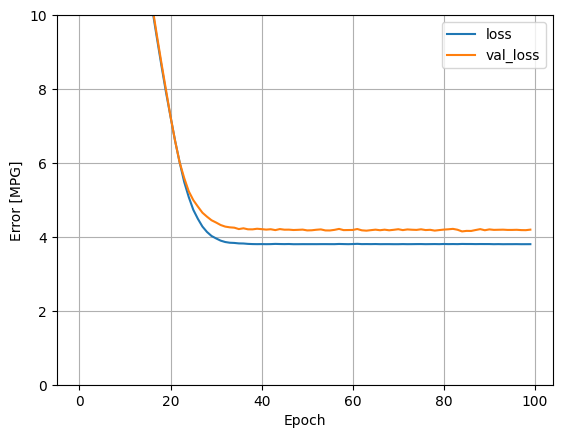

In [ ]:
plot_loss(history)


Predict and compares results:

In [ ]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

8/8 [==============================] - 0s 3ms/step


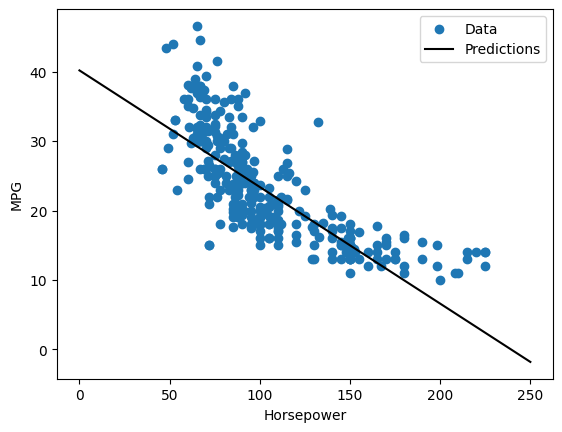

In [ ]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)
plot_horsepower(x, y)

Now we can try LR with multiple inputs:

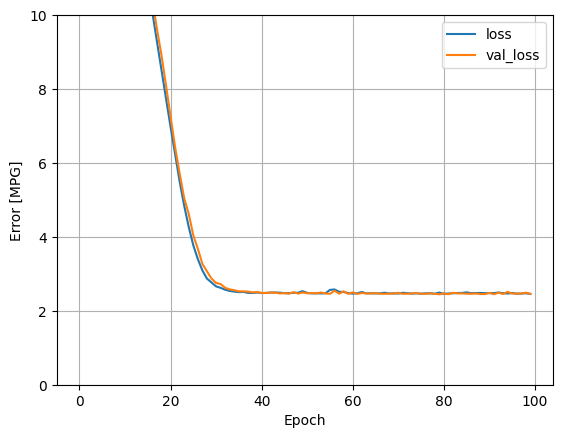

In [ ]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

plot_loss(history)

In [ ]:
test_results={}
test_results['linear_model']=linear_model.evaluate(
    test_features, test_labels, verbose=0)

And now we can try with a deeper neural network:

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense_2 (Dense)             (None, 64)                512       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4752 (18.57 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [ ]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

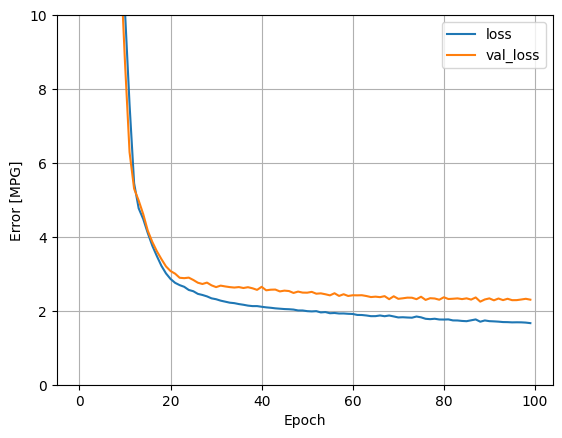

In [ ]:
plot_loss(history)

In [ ]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).transpose()

,Mean absolute error [MPG]
linear_model,2.440708
dnn_model,1.776948


3/3 [==============================] - 0s 4ms/step


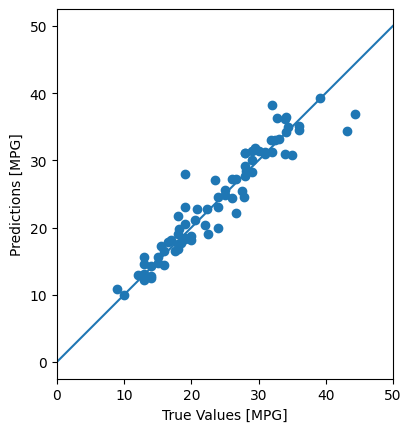

In [ ]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.plot(lims, lims)

# Try building a model:

In [ ]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(1)
  ])
  model.compile(loss='mean_absolute_error',
                optimizer="sgd")
  return model

In [ ]:
my_model = build_and_compile_model(normalizer)
my_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 7)                 15        
 on)                                                             
                                                                 
 dense_9 (Dense)             (None, 1)                 8         
                                                                 
Total params: 23 (96.00 Byte)
Trainable params: 8 (32.00 Byte)
Non-trainable params: 15 (64.00 Byte)
_________________________________________________________________


In [ ]:
history = my_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

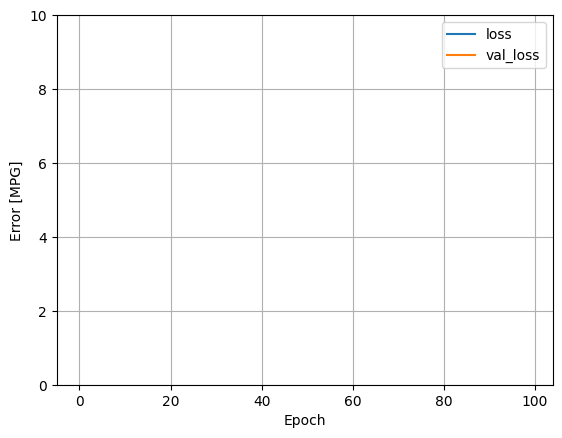

In [ ]:
plot_loss(history)

In [ ]:
test_results['my_model'] = my_model.evaluate(test_features, test_labels, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).transpose()

,Mean absolute error [MPG]
linear_model,2.440708
dnn_model,1.776948
my_model,15.948336
